# Import Tensorflow and other libraries

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [2]:
import tensorflow as tf

In [3]:
tf.__version__

'2.1.0-dev20191109'

In [4]:
# # 用于生成 GIF 图片
# !pip install -q imageio

In [5]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

# 加载和准备数据集 

In [6]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

In [7]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float')
train_images = (train_images - 127.5) / 127.5 # 将图片标准化到[-1, 1]区间内

In [8]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [9]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# 创建模型 

In [10]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # 注意：batch size 没有限制

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

In [11]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

print(generated_image)

tf.Tensor(
[[[[-2.64264923e-03]
   [ 1.29389786e-03]
   [-3.24186985e-03]
   [-2.14251713e-03]
   [-8.55765771e-04]
   [-5.77983074e-03]
   [-1.10400561e-02]
   [ 2.04907241e-03]
   [ 7.16147432e-03]
   [-6.55235304e-03]
   [ 4.92025772e-03]
   [-3.48467263e-03]
   [ 5.65681793e-03]
   [-1.80444028e-02]
   [-9.55817010e-03]
   [-1.12478603e-02]
   [-2.91372620e-04]
   [-6.01958670e-03]
   [-8.22317693e-03]
   [-4.76076879e-04]
   [ 9.82867181e-03]
   [-9.92061943e-03]
   [-7.07862526e-03]
   [ 3.55043449e-03]
   [ 5.52012818e-03]
   [-5.17550297e-03]
   [ 6.63660187e-03]
   [-1.69639953e-03]]

  [[-7.92994048e-04]
   [-7.75888190e-03]
   [ 5.23280771e-03]
   [ 2.86620553e-03]
   [ 8.75270739e-03]
   [-1.28396824e-02]
   [ 4.68951790e-03]
   [-5.70321828e-03]
   [-1.67551506e-02]
   [-4.13780706e-03]
   [-1.93556603e-02]
   [-2.26888917e-02]
   [-1.01170167e-02]
   [-2.68653166e-02]
   [ 1.81788448e-02]
   [-1.86203253e-02]
   [-9.54455754e-04]
   [-1.60255637e-02]
   [ 5.14031667e-03]


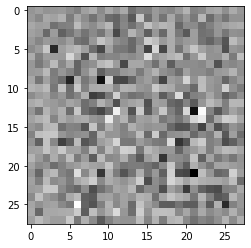

In [12]:
# # tensorflow v1 style
# with tf.Session() as sess:
#   sess.run(tf.global_variables_initializer())
#   generated_image = sess.run(generated_image)
# plt.imshow(generated_image[0, :, :, 0], cmap='gray')

# tensorflow v2 style
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [13]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                           input_shape=[28, 28, 1]))
    
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    
    return model

In [14]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[-0.00083993]], shape=(1, 1), dtype=float32)


# 定义损失函数和优化器

In [15]:
# 该方法返回计算交叉熵损失的辅助函数
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# 判别器损失 

In [16]:
# 该方法量化判别器从判断真伪图片的能力。它将判别器对真实图片的预测值与值全为 1 的
# 数组进行对比，将判别器对伪造（生成的）图片的预测值与值全为 0 的数组进行对比。
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# 生成器损失

In [17]:
# 生成器损失量化其欺骗判别器的能力。直观来讲，如果生成器表现良好，判别器将会把伪造图片判断为真实图片（或 1）。这里我们将把判别器在生成图片上的判断结果与一个值全为 1 的数组进行对比。
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [18]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# 保存检查点

In [19]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# 定义训练循环

In [20]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16


# 我们将重复使用该种子（因此在动画 GIF 中更容易可视化进度）
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [21]:
# 注意 `tf.function` 的使用
# 该注解使函数被“编译”
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [22]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # 继续进行时为 GIF 生成图像
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # 每 15 个 epoch 保存一次模型
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # 最后一个 epoch 结束后生成图片
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

## 生成与保存图片

In [23]:
def generate_and_save_images(model, epoch, test_input):
  # 注意 training` 设定为 False
  # 因此，所有层都在推理模式下运行（batchnorm）。
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

# 训练模型

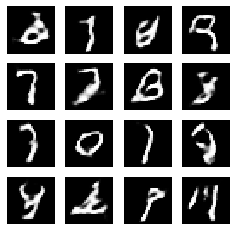

CPU times: user 7h 26min 55s, sys: 4min 37s, total: 7h 31min 32s
Wall time: 1h 22min 31s


In [24]:
%%time
train(train_dataset, EPOCHS)

## 恢复最新的检查点

In [25]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

# 创建 GIF

In [26]:
# 使用 epoch 数生成单张图片
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

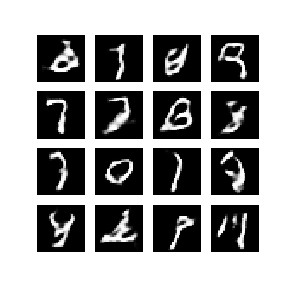

In [31]:
display_image(EPOCHS)

In [28]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)